# Libraries

In [1]:
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
from textblob import TextBlob
from collections import Counter
import re
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

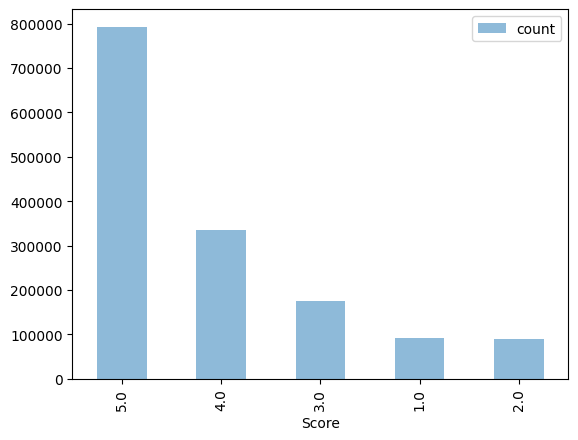


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [2]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [3]:
def count_matching_reviews(df, star_rating, search_string):
    """
    Count the number of reviews with a given star rating that contain a specific string.

    Parameters:
    df (pd.DataFrame): The dataframe containing the reviews and star ratings.
    star_rating (int): The star rating to filter reviews by (1 to 5).
    search_string (str): The string to search for in the reviews.

    Returns:
    int: The number of reviews that match the search criteria.
    """
    # Convert the search string to lowercase for case-insensitive search
    search_string = search_string.lower()

    # Filter the dataframe by the given star rating
    filtered_reviews = df[df['Score'] == star_rating]

    # Search for the string in the 'Text' column of the filtered reviews
    matching_reviews = filtered_reviews[filtered_reviews['Text'].str.contains(search_string, case=False, na=False)]

    # Return the count of matching reviews
    return len(matching_reviews)

# Example usage:
star_rating = 1
search_string = "great"
matching_review_count = count_matching_reviews(trainingSet, star_rating, search_string)

# Print the count of matching reviews
print(f"Number of matching reviews with a {star_rating}-star rating: {matching_review_count}")


Number of matching reviews with a 1-star rating: 13444


In [4]:
def search_in_star_reviews(df, star_rating, search_string, num_reviews=None):
    """
    Search for a specific string in reviews with a given star rating and return a specific number of matching reviews.

    Parameters:
    df (pd.DataFrame): The dataframe containing the reviews and star ratings.
    star_rating (int): The star rating to filter reviews by (1 to 5).
    search_string (str): The string to search for in the reviews.
    num_reviews (int): Number of reviews to return. If None, return all matching reviews.

    Returns:
    pd.DataFrame: DataFrame containing reviews that match the search criteria.
    """
    # Convert the search string to lowercase for case-insensitive search
    search_string = search_string.lower()

    # Filter the dataframe by the given star rating
    filtered_reviews = df[df['Score'] == star_rating]

    # Search for the string in the 'Text' column of the filtered reviews
    matching_reviews = filtered_reviews[filtered_reviews['Text'].str.contains(search_string, case=False, na=False)]

    # Return the specified number of reviews, if num_reviews is provided
    if num_reviews:
        return matching_reviews.head(num_reviews)
    else:
        return matching_reviews

# Example usage:
star_rating = 1
search_string = "great"
num_reviews = 10  # Specify the number of reviews to return
matching_reviews = search_in_star_reviews(trainingSet, star_rating, search_string, num_reviews)

# Print the matching reviews (or process them as needed)
print(matching_reviews[['Id', 'Text']])  # Display review Id and text


           Id                                               Text
53      91998  Come on people. This was a terrible movie. I b...
278    624980  Do not waste your money on this garbage. Anyon...
290   1299216  In Butchered 7 dopey teenagers spend their las...
344    767517  Yup, not to marginalize the other people who m...
485    693933  Picking up 10 years later, Anakin Skywalker is...
553     16865  This movie was one of the worst wastes of film...
808   1189752  I'll try to be as kind as I can to this traves...
832     19643  I must have missed something. With all the lov...
1084   637712  Peter Jackson has gone from talented visionary...
1172  1262524  This pathetic film is'nt even a watered down v...


In [5]:
stop_words = [
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves',
    'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him',
    'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its',
    'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what',
    'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am',
    'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has',
    'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the',
    'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while',
    'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between',
    'into', 'through', 'during', 'before', 'after', 'above', 'below',
    'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over',
    'under', 'again', 'further', 'then', 'once', 'here', 'there',
    'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each',
    'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor',
    'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's',
    't', 'can', 'will', 'just', 'don', 'should', 'now',
    'say', 'says', 'said', 'say', 'tell', 'told', 'could', 'would',
    'should', 'might', 'must', 'shall', 'may', 'like', 'as', 'into',
    'over', 'after', 'before', 'up', 'down', 'again', 'out', 'since',
    'while', 'where', 'yet', 'so', 'because', 'that',
    'if', 'whether', 'whether', 'both', 'either', 'neither', 'each',
    'few', 'less', 'least', 'most', 'much', 'more', 'many', 'nobody',
    'somebody', 'everybody', 'anybody', 'noone', 'nothing', 'everything',
    'anything', 'one', 'two', 'three', 'first', 'second', 'third',
    'next', 'last', 'same', 'different', 'much', 'more', 'less', 'least',
    'either', 'neither', 'either', 'nor', 'whether', 'whoever', 'whomever', 
    'whatever', 'whichever', 'whatsoever',
    'the', 'and', 'is', 'in', 'to', 'of', 'it', 'a', 'that', 'this', 
    'for', 'with', 's', 'as', 'was', 'you', 'movie', 'on', 'but', 
    'are', 'his', 'her', 'one', 'film', 'he', 'she', 'have', 'all', 
    'not', 't', 'be', 'by', 'from', 'who', 'an', 'they', 'so', 
    'at', 'my', 'has', 'there', 'if', 'about', 'out', 'or', 'just', 'will', 
    'movies', 'films', 'story', 'dvd', 'time', 'people'
]

In [6]:
def get_top_words_by_rating_chunked(df, star_rating, stop_words=None, top_n=10, chunk_size=10000):
    if stop_words is None:
        stop_words = []
    
    word_counts = Counter()
    
    # Filter DataFrame by the specified star rating in chunks
    filtered_df = df[df['Score'] == star_rating]
    
    for start in range(0, len(filtered_df), chunk_size):
        chunk = filtered_df[start:start+chunk_size]
        combined_text = ' '.join(chunk['Text'].fillna(''))
        
        # Tokenize and remove stop words
        words = re.findall(r'\b\w+\b', combined_text.lower())
        filtered_words = [word for word in words if word not in stop_words]
        
        # Update the word counts
        word_counts.update(filtered_words)
    
    # Get the top N most common words
    most_common_words = word_counts.most_common(top_n)
    
    # Convert the words into a set
    top_words_set = set([word for word, freq in most_common_words])
    
    return top_words_set

# Example of processing in smaller chunks
top_words_5 = get_top_words_by_rating_chunked(trainingSet, star_rating=5, stop_words=stop_words)
top_words_4 = get_top_words_by_rating_chunked(trainingSet, star_rating=4, stop_words=stop_words)
top_words_3 = get_top_words_by_rating_chunked(trainingSet, star_rating=3, stop_words=stop_words)
top_words_2 = get_top_words_by_rating_chunked(trainingSet, star_rating=2, stop_words=stop_words)
top_words_1 = get_top_words_by_rating_chunked(trainingSet, star_rating=1, stop_words=stop_words)
print("Top words for rating 5:", top_words_5)
print("Top words for rating 4:", top_words_4)
print("Top words for rating 3:", top_words_3)
print("Top words for rating 2:", top_words_2)
print("Top words for rating 1:", top_words_1)

Top words for rating 5: {'well', 'show', 'get', 'great', 'really', 'good', 'best', 'love', 'also', 'see'}
Top words for rating 4: {'well', 'way', 'get', 'great', 'really', 'good', 'still', 'also', 'see', 'even'}
Top words for rating 3: {'well', 'way', 'get', 'great', 'really', 'good', 'better', 'also', 'see', 'even'}
Top words for rating 2: {'bad', 'make', 'well', 'way', 'get', 'really', 'good', 'better', 'see', 'even'}
Top words for rating 1: {'bad', 'make', 'watch', 'way', 'get', 'made', 'really', 'good', 'see', 'even'}


In [7]:
# Function to get all words by rating in chunks
def get_all_words_by_rating(df, star_rating, stop_words=None, chunk_size=10000):
    if stop_words is None:
        stop_words = []
    
    # Initialize a set to hold all words for the specified rating
    all_words_set = set()
    
    # Get the number of chunks
    num_chunks = int(np.ceil(len(df) / chunk_size))
    
    for i in range(num_chunks):
        # Get the chunk
        chunk = df[i*chunk_size:(i+1)*chunk_size]
        
        # Filter the chunk by the specified star rating
        filtered_chunk = chunk[chunk['Score'] == star_rating]
        
        # Combine all the texts for the specified rating into one string
        combined_text = ' '.join(filtered_chunk['Text'].fillna(''))
        
        # Tokenize the text: remove punctuation and split into words
        words = re.findall(r'\b\w+\b', combined_text.lower())
        
        # Remove stop words
        filtered_words = [word for word in words if word not in stop_words]
        
        # Update the set of words
        all_words_set.update(filtered_words)
    
    return all_words_set

# Get words for each star rating
words_5 = get_all_words_by_rating(trainingSet, star_rating=5, stop_words=stop_words)
words_4 = get_all_words_by_rating(trainingSet, star_rating=4, stop_words=stop_words)
words_3 = get_all_words_by_rating(trainingSet, star_rating=3, stop_words=stop_words)
words_2 = get_all_words_by_rating(trainingSet, star_rating=2, stop_words=stop_words)
words_1 = get_all_words_by_rating(trainingSet, star_rating=1, stop_words=stop_words)


# Calculate common words using set intersections
common_words = set()

# For each combination, find common words and add to the common_words set
common_words.update(words_5.intersection(words_1, words_2, words_3))
common_words.update(words_4.intersection(words_2, words_1))
common_words.update(words_3.intersection(words_5, words_1))
common_words.update(words_2.intersection(words_5, words_4))
common_words.update(words_1.intersection(words_3, words_4, words_5))

# Calculate unique words for each rating
unique_words_5 = words_5 - common_words
unique_words_4 = words_4 - common_words
unique_words_3 = words_3 - common_words
unique_words_2 = words_2 - common_words
unique_words_1 = words_1 - common_words

In [8]:
def add_features_to(df):
    # This is where you can do all your feature extraction

    df['Polarity'] = df['Text'].apply(lambda x: TextBlob(x).sentiment.polarity)
    df['Subjectivity'] = df['Text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

    # Common words for each star
    common_words_star_5 = unique_words_5
    common_words_star_4 = unique_words_4
    common_words_star_3 = unique_words_3
    common_words_star_2 = unique_words_2
    common_words_star_1 = unique_words_1
    
    def calc_common_word_frequency(text, common_words):
        # Convert review to lowercase and split into words
        words = str(text).lower().split() if text is not None else []
        total_count = len(words)  # Total number of words
        
        # Count occurrences of common words
        common_word_count = sum(1 for word in words if word in common_words)
        
        # Calculate frequency
        frequency = common_word_count / total_count if total_count > 0 else 0  # Avoid division by zero
        
        return frequency

    df['Freq_Star_5'] = df['Text'].apply(lambda x: calc_common_word_frequency(x, common_words_star_5))
    df['Freq_Star_4'] = df['Text'].apply(lambda x: calc_common_word_frequency(x, common_words_star_4))
    df['Freq_Star_3'] = df['Text'].apply(lambda x: calc_common_word_frequency(x, common_words_star_3))
    df['Freq_Star_2'] = df['Text'].apply(lambda x: calc_common_word_frequency(x, common_words_star_2))
    df['Freq_Star_1'] = df['Text'].apply(lambda x: calc_common_word_frequency(x, common_words_star_1))
    
    return df

# # Load the feature extracted files if they've already been generated
# if exists('./data/X_train.csv'):
#     X_train = pd.read_csv("./data/X_train.csv")
# if exists('./data/X_submission.csv'):
#     X_submission = pd.read_csv("./data/X_submission.csv")

# else:
#     # Process the DataFrame
#     train = add_features_to(trainingSet)

#     # Merge on Id so that the submission set can have feature columns as well
#     X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
#     X_submission = X_submission.drop(columns=['Score_x'])
#     X_submission = X_submission.rename(columns={'Score_y': 'Score'})

#     # The training set is where the score is not null
#     X_train =  train[train['Score'].notnull()]

#     X_submission.to_csv("./data/X_submission.csv", index=False)
#     X_train.to_csv("./data/X_train.csv", index=False)
# # Process the DataFrame
train = add_features_to(trainingSet)

# Merge on Id so that the submission set can have feature columns as well
X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
X_submission = X_submission.drop(columns=['Score_x'])
X_submission = X_submission.rename(columns={'Score_y': 'Score'})

# The training set is where the score is not null
X_train =  train[train['Score'].notnull()]

X_submission.to_csv("./data/X_submission.csv", index=False)
X_train.to_csv("./data/X_train.csv", index=False)

# Sample + Split into training and testing set

In [9]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

# Feature Selection

In [33]:
features = ['Time', 'Freq_Star_5', 'Freq_Star_4', 'Freq_Star_3', 'Freq_Star_2', 'Freq_Star_1']

X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

# Model Creation

In [34]:
# Learn the model
model = KNeighborsClassifier(n_neighbors=3).fit(X_train_select, Y_train)

# Predict the score using the model
Y_test_predictions = model.predict(X_test_select)

# Model Evaluation

Accuracy on testing set =  0.43620063769739537


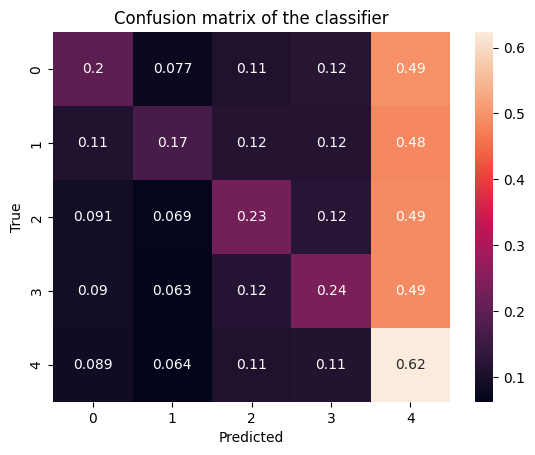

: 

In [35]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [13]:
# Create the submission file
X_submission['Score'] = model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)